# Average Time in Hot 100
In this file, we are going to analyze how long (on average) popular songs remain popular. First we are going to consider songs that hit the top 10. For each of those songs, we will see how many weeks it was in the top 10, and average that across years to see if there are any interesting trends.

We will then repeat this process, but see how many weeks those songs remained in the top 100. Finally, we try to plot a song's position within the top charts over time, and see how this changes for songs over the years.

In [98]:
import pandas as pd
import pickle

First let's get a set of unique songs that were at some point in the top n

In [99]:
# Want the songs above top_cuttoff, and want to see how long they were in the top length_in
TOP_CUTTOFF = 10
LENGTH_IN = 100

In [100]:
# returns a dict mapping a year to a set of songs that were in the top n at some point that year
def get_uniques(top_df):
    topN = top_df[top_df['position'] <= TOP_CUTTOFF]
    uniques = topN.groupby(topN.date.dt.year)['name'].apply(set)

    return dict(uniques)

Now for each of these sets, let's get the number of times that song was in the top n

In [101]:
def song_count_top(top_df, song, year):
    result = top_df[top_df['date'].dt.year == year]
    result = result[result['name'] == song]
    result = result[result['position'] <= LENGTH_IN]
    return len(result)

def song_average_top(top_df, songs, year):
    total = 0
    for song in songs:
        total += song_count_top(top_df, song, year)
    
    return total / len(songs)

def yearly_average(top_df):    
    result = []
    uniques = get_uniques(top_df)
    
    for year, songs in uniques.items():
        avg = song_average_top(top_df, songs, year)
        result += [(year, avg)]

    return result

In [102]:
with open('../data/results/hot100.df', 'rb') as f:
    df = pickle.load(f)

df['date'] = pd.to_datetime(df['date'])
avg = yearly_average(df)

In [130]:
import matplotlib.pyplot as plt
from statistics import mean

def divide_chunks(l, n):
    result = []
    for i in range(0, len(l), n):  
        if i >= len(l):
            result += [l[i:]]
        else:
            result += [l[i:i + n]]
    return result

def plot_avg(smoothing=1):
    years    = [elem[0] for elem in avg[::smoothing]]
    averages = [elem[1] for elem in avg]
    
    data = divide_chunks(averages, smoothing)
    data = list(map(mean, data))
    
    plt.plot(years, data)
    plt.xlabel('Year')
    plt.ylabel('Weeks')
    plt.title('Average Number of Weeks in Top %s' % LENGTH_IN)
    
    plt.show()

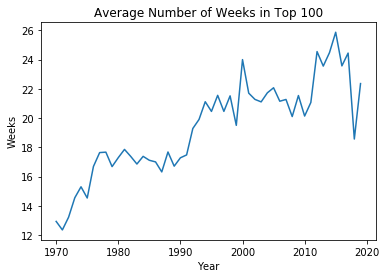

In [136]:
plot_avg(1)